# Random Forest

Definition of a Random Forest
---

### Improving on Decision Trees

The main drawback of decision trees is their tendency to overfit. We can improve their performance with pruning techniques, but this module will introduce a better model. 

Decision trees are very susceptible to random idiosyncrasies in the training dataset. They have very high variance, which means if you randomly select the training dataset, you end up with very different models.

One advantage of decision trees over models like logistic regression is that they make no assumptions about how the data is structured. In logistic regression, we assume to draw a line to split the data points. Sometimes when the data is not structured like that, decision trees can still capture the essence of the data.

This module is about **random forests**. As its name suggests, it is a model built with multiple trees. The goal of random forests is to take advantage of decision trees while mitigating the variance issue.

### Bootstrap Aggregation

A **bootstrapping sample** is a random sample of data points where we randomly select with replacement data points from our original dataset to create a dataset of the same size. For example, if we have four data points $A, B, C, D$, these could be 3 resamples:

In [1]:
import numpy as np


data = np.array(list("ABCD"))
for _ in range(3):
    print(np.random.choice(data, size=data.size))

['C' 'B' 'A' 'A']
['A' 'B' 'D' 'C']
['B' 'B' 'A' 'C']


**Bootstrap Aggregation** (or **Bagging**) is a technique for reducing the variance in an individual model by creating an ensemble from multiple models built on bootstrapped samples. To make a prediction, we take the predictions of all the base models.

### Decorrelate the Trees

With bagged decision trees, the trees may still be too similar to create an ideal model. We also **decorrelate the trees** by limiting their access to the features of a dataset. At every node, we randomly select a subset of all features to consider when splitting. _It's important to note that the random selection of features happens at each node._ A standard choice for the number of features to consider at each split is the square root of the number of features.

Now when we bag these decision trees, we get a **random forest**. Although each decision tree may perform worse than a standard decision tree, the ensemble should perform well and become less prone to variance in a dataset.

## Random Forest with Scikit-Learn

### Review of Breast Cancer Dataset

Recall that the dataset has measures of different attributes of a lump in breast tissue and whether the tumor is benign or malignant. Again, we prepare the data.

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer


cancer_data = load_breast_cancer()
feature_names = cancer_data["feature_names"]
df = pd.DataFrame(cancer_data["data"], columns=feature_names)
df["target"] = cancer_data["target"]

X = df[feature_names].values
y = df["target"].values

print(f"{X.shape = }")
print(f"{y.shape = }")

X.shape = (569, 30)
y.shape = (569,)


### Building and Using a Random Forest

The process of building and using a random forest is similar to that for Logistic Regression and Decision Trees. _The builders of scikit-learn intentionally made it so that it would be easy to switch between and compare different models. You can see for yourself at the end of this section._

We first import that model.

In [3]:
from sklearn.ensemble import RandomForestClassifier

Then, we split the dataset into a training set and test set like before. _We set the random seed so that the results are replicable for demonstration purposes._

In [4]:
from sklearn.model_selection import train_test_split


seed = 195512  # The year and month the first AI program is created.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

Then we create a `RandomForestClassifier` object and train the model.

In [5]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Now we can use the model to make a prediction. For example, let's take the first row of the test set and see what the prediction is.

In [6]:
first_row = X_test[0].reshape(1, -1)
first_pred, = rf.predict(first_row)
print("prediction", first_pred)
print("true value", y_test[0])

prediction 1
true value 1


These results mean that the model predicted that the lump was cancerous and it was correct. We can further test the model's accuracy over the whole test set.

In [7]:
print("accuracy", rf.score(X_test, y_test))

accuracy 0.986013986013986


The accuracy is about $98.6\%$. We can compare its performance against the Decision Tree model.

In [8]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("accuracy", dt.score(X_test, y_test))

accuracy 0.9440559440559441


The accuracy of the decision tree is about $93.7\%$, which is much worse than the random forest.

_Note how easy it is to switch between models and compare them in scikit-learn._

## Tuning a Random Forest

### Random Forest Parameters

To learn about all the attributes of the `RandomForestClassifier` in scikit-learn, read its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Since a random forest is made up of decision trees, we have all the same tuning parameters for pre-pruning as we do for decision trees: `max_depth`, `min_sample_leaf`, `max_leaf_nodes` etc. With random forests, it is generally not important to tune these as overfitting is generally not the primary issue.

We will take a look at two new tuning parameters:
- `n_estimators` - the number of trees;<br>
  The default for this parameter is 10. This often works but may in some cases be too small.
- `max_features` - the number of features to consider at each split.<br>
  Recall that the default for this parameter is the square root of the number of features (or predictors).

_One big advantage of Random Forests is that they rarely need much tuning. The default values work well on most datasets._

### Grid Search

Recall from the [Decision Tree notebook](attachment:./DecisionTree.ipynb), scikit-learn has built in a Grid Search class to help us find the optimal choice of parameters.

First, we need to define the parameter grid with the name and values of the parameters to try.

In [9]:
param_grid_gs = {
    "n_estimators": np.arange(5, 51, 5)
}
param_grid_gs

{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}

Then, we can create a Random Forest model and a Grid Search object. Recall that the Grid Search will do k-fold cross validation for us. We set it to 5-fold cross validation.

In [10]:
from sklearn.model_selection import GridSearchCV


rf_gs = RandomForestClassifier(random_state=seed)
gs = GridSearchCV(rf_gs, param_grid_gs, cv=5)

Now we use the `fit` method to run the grid search against our data. We print out the best parameters.

In [11]:
gs.fit(X, y)
gs.best_params_

{'n_estimators': 45}

This is the parameter value that yields the highest accuracy, which is the default metric. The results vary from run to run as the 5-fold cross validation is random.

Using the default metric works fine for this dataset as the classes are reasonably balanced. If the classes are imbalanced, we would want to use an alternative metric, like the f1-score. We can achieve this by setting the `scoring` parameter to `"f1"`.

### Elbow Graph

With parameters like the number of trees in a random forest, increasing it will always increase performance until it levels out. However, in a random forest, the more trees we have, the more complicated the algorithm. A more complicated algorithm is more resource intensive.

**Elbow Graph** is a model that optimizes performance without adding unnecessary complexity. To find the optimal value, we perform a Grid Search as before. But instead of looking at the best parameter values, we plot the test score against the number of estimators. The test score is stored in `cs_results_` attribute under the key `"mean_test_score"`.

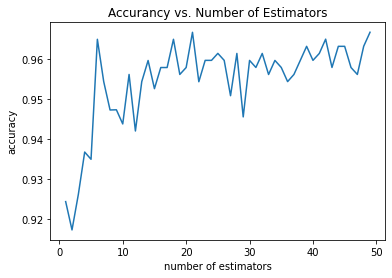

In [12]:
import matplotlib.pyplot as plt

n_estimators = np.arange(1, 50)

param_grid_eg = {
    "n_estimators": n_estimators
}

rf_eg = RandomForestClassifier(random_state=seed)
gs_eg = GridSearchCV(rf, param_grid_eg, cv=5)
gs_eg.fit(X, y)

scores = gs_eg.cv_results_["mean_test_score"]

plt.plot(n_estimators, scores)
plt.title("Accurancy vs. Number of Estimators")
plt.xlabel("number of estimators")
plt.ylabel("accuracy")
plt.show()

Looking at the graph, we see that at about 10 decision trees the graph levels out. We should choose about 10 as our number of estimators, because it yields about the maximum performance with the minimum number of estimators. With this knowledge, we build our final random forest model.

In [13]:
rf_final = RandomForestClassifier(n_estimators=10)
rf_final.fit(X, y)

RandomForestClassifier(n_estimators=10)

## Feature Importance

### Feature Importance

Not all features in the dataset contribute equally to building a model. The decision of which subset of features to use is called **feature selection**.

Random forests provide a straightforward method for feature selection: **mean decrease impurity**. Recall that a random forest consists of decision trees, and that for each tree, the node is chosen to split the dataset based on maximum decrease in impurity.Thus, for a forest, it is possible to compute how much impurity each features decreases on average in a tree. Consider this measure a metric of **feature importance**, which we can then rank and use to select features.

The feature importance metric is provided as a variable with the random forest model. The values are scaled so they add up to 1. Let us see the importance of all features in our final model of the last section.

In [14]:
ft_imp = pd.Series(rf_final.feature_importances_,index=feature_names)
ft_imp.sort_values(ascending=False, inplace=True)
ft_imp

mean concavity             0.175604
worst perimeter            0.122003
worst radius               0.120355
mean concave points        0.111359
worst concave points       0.085385
mean radius                0.067230
radius error               0.045832
worst area                 0.042066
mean compactness           0.040257
mean perimeter             0.029187
worst texture              0.019877
area error                 0.016880
mean texture               0.016640
worst smoothness           0.015063
worst symmetry             0.012208
mean area                  0.011622
concave points error       0.009309
symmetry error             0.007771
perimeter error            0.007280
compactness error          0.006854
smoothness error           0.006569
mean symmetry              0.005961
worst compactness          0.005095
concavity error            0.004946
mean fractal dimension     0.004562
worst fractal dimension    0.004525
worst concavity            0.002056
fractal dimension error    0

### New Model with Selected Features

The top reason for feature selection is that it reduces the complexity of a model; it enables us to train a model faster and makes it easier to interpret. If the right subset is chosen, it can remove some noise and highly correlated features, resulting in increased accuracy.

In [15]:
imp_features = ft_imp.index[:10]
X_ft = df[imp_features]
X_train_ft, X_test_ft, y_train_ft, y_test_ft = \
    train_test_split(X_ft, y, random_state=seed)

rf_ft = RandomForestClassifier()
rf_ft.fit(X_train_ft, y_train_ft)
rf_ft.score(X_test_ft, y_test_ft)

0.958041958041958

We can see we reduced the complexity of our model by a factor of $3$ while maintaining the accuracy. The advantage is especially profound if the sample size is large.

_There is no best feature selection method universally. Choosing the right subset often relies on domain knowledge._

## Pros and Cons

### Performance

The biggest advantage of random forests is that they generally perform well without any tuning.

They will also perform decently well on almost every dataset. A linear model, for example, cannot perform well on a dataset that cannot be split with a line. However, a random forest will perform just fine on such a dataset.

### Interpretability

Random forests, despite being made up of decision trees, are not as easy to interpret. A random forest has several decision trees, each of which is NOT a very good model, only when averaged create an excellent model.

### Computation

Random forests can be a little slow to build, especially with increasing number of estimators. Although each decision tree in the ensemble is easier to build, given the quantity of decision trees it is often slow to build. Similarly, predicting with a random forest will also be slower than a standard decision tree.